In [1]:
#Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import joblib
import warnings

In [2]:
#Load Dataset
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
#Feature engineering

def preprocess_data(data):
    data=data.copy()
    
    #Extract title from name
    data['title']=data['Name'].str.extract(r',\s*([^\.]+)\.')
    data['title']=data['title'].replace(['Lady','Countess','Capt','Col','Don','Dr',
                                       'Major','Rev','Sir','Jonkheer','Dona'],'Rare')
    data['title']=data['title'].replace(['Mlle','Ms'],'Miss')
    data['title']=data['title'].replace('Mme','Mr')

    #Family size and Alone Feature
    data['FamilySize']=data['SibSp']+data['Parch']+1
    data['IsAlone']=(data['FamilySize']==1).astype(int)

    #drop unrelevent Columns
    col=['PassengerId','Name','Ticket','Cabin']

    for c in col:
        if c in data.columns:
            data.drop(columns=c,inplace=True)

    return data

train_data=preprocess_data(train)
train_data.head()


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,title,FamilySize,IsAlone
0,0,3,male,22.0,1,0,7.2500,S,Mr,2,0
1,1,1,female,38.0,1,0,71.2833,C,Mrs,2,0
2,1,3,female,26.0,0,0,7.9250,S,Miss,1,1
3,1,1,female,35.0,1,0,53.1000,S,Mrs,2,0
4,0,3,male,35.0,0,0,8.0500,S,Mr,1,1


In [5]:
#Split Data
# Separate target and features
X = train_data.drop(columns=['Survived'])
y = train_data['Survived']


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [6]:
#Preprocessing + Model Pipeline

#select data on data type
numeric_data=X.select_dtypes(include=['int64','float64']).columns.tolist()
category_data=X.select_dtypes(include='object').columns.tolist()

#Transformers
numeric_transformer=Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='median')),
    ('scaler',StandardScaler())
])

category_transformer=Pipeline(
    steps=[
        ('imputer',SimpleImputer(strategy='most_frequent')),
        ('onehot',OneHotEncoder(handle_unknown='ignore'))
    ]
)

#Column Transformer
preprocessor=ColumnTransformer(
    transformers=[
        ('num',numeric_transformer,numeric_data),
        ('cat',category_transformer,category_data)
    ]
)


#Full Pipeline
model=Pipeline(steps=[
    ('preprocessor',preprocessor),
    ('classifier',RandomForestClassifier(n_estimators=100,random_state=42))
])

In [7]:
#Train the model
model.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Pclass', 'Age', 'SibSp',
                                                   'Parch', 'Fare',
                                                   'FamilySize', 'IsAlone']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Sex', 'Embarked',
                                                   'title'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

Accuracy Score : 0.8212290502793296

Classification report :
               precision    recall  f1-score   support

           0       0.87      0.84      0.86       114
           1       0.74      0.78      0.76        65

    accuracy                           0.82       179
   macro avg       0.81      0.81      0.81       179
weighted avg       0.82      0.82      0.82       179



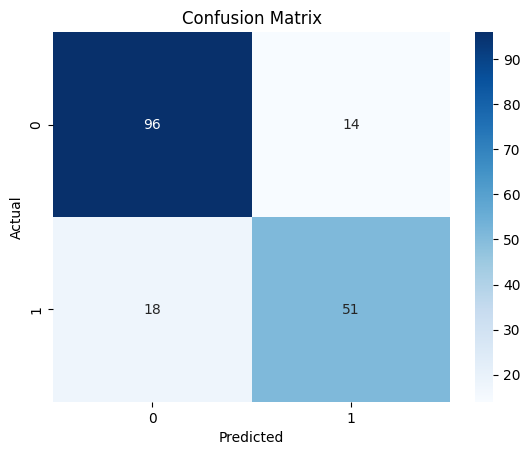

In [8]:
#Evalute model
y_pred=model.predict(X_test)

print('Accuracy Score :',accuracy_score(y_pred,y_test))
print('\nClassification report :\n',classification_report(y_pred,y_test))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [9]:
#Save the model
joblib.dump(model,'titanic_model.joblib')
print("Model saved successfully as titanic_model.joblib")

Model saved successfully as titanic_model.joblib
